In [91]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import pearsonr, chi2_contingency, chisquare

warnings.filterwarnings('ignore')

# Считывание и предобработка данных

## Базовая обработка

In [21]:
df = pd.read_csv('../Health_cleaned_income_delta.csv')

In [22]:
df.head()

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,riearn_delta,siearn_delta,ripena_delta,sipena_delta,rgov_delta,sgov_delta,total_work_income_delta,total_pension_income_delta,total_gov_income_delta,total_income_delta
0,22861040,1,2,0,2,1992-04-01,62,56,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25154020,1,2,0,2,1992-04-01,56,59,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25181010,1,2,0,1,1992-04-06,58,53,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11067020,1,2,0,1,1992-04-07,53,50,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22861010,1,1,0,2,1992-04-07,56,62,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.columns

Index(['hhidpn', 'rmstat', 'ragender', 'rahispan', 'raracem', 'riwbegy',
       'ragey_b', 'sagey_b', 'rhltc', 'rhlthlm', 'rhibpe', 'rdiabe', 'rcancre',
       'rlunge', 'rhearte', 'rstroke', 'rpsyche', 'rarthre', 'rhosp',
       'rhspnit', 'oop_spend', 'riearn', 'ripena', 'siearn', 'sipena', 'rcovr',
       'rcovs', 'rlbrf', 'rjphys', 'rjlift', 'rjweeks', 'rjweek2', 'rjcten',
       'index_wave', 'insured_gov', 'uninsured', 'retired', 'collegeplus',
       'year', 'cpi', 'rgov', 'sgov', 'inter_year', 'year_of_birth',
       'total_work_income', 'total_pension_income', 'total_gov_income',
       'total_income', 'without_work', 'n_jobs', 'riearn_delta',
       'siearn_delta', 'ripena_delta', 'sipena_delta', 'rgov_delta',
       'sgov_delta', 'total_work_income_delta', 'total_pension_income_delta',
       'total_gov_income_delta', 'total_income_delta'],
      dtype='object')

In [24]:
df['rhltc'].value_counts()

3     101577
4      33612
.m     15862
2      12860
5       3753
1       3097
Name: rhltc, dtype: int64

In [25]:
def reformat_rhltc(el):
    if el == '.m':
        return el
    return 3 - int(el)

df['rhltc'] = df['rhltc'].apply(reformat_rhltc)
df['rhltc'].value_counts()

0     101577
-1     33612
.m     15862
1      12860
-2      3753
2       3097
Name: rhltc, dtype: int64

## Создание датафрейма с "группами брака"

In [36]:
rmstat_df = df[(df['rmstat'] != '.m') & (df['rhltc'] != '.m')]

In [37]:
rmstat_df.shape

(154799, 60)

In [38]:
rmstat_df['rmstat'] = rmstat_df['rmstat'].astype(int)
rmstat_df['rmstat'].value_counts().sort_index()

1    97981
2     1121
3     4483
4     2430
5    13697
6     1057
7    29037
8     4993
Name: rmstat, dtype: int64

In [39]:
amount_of_statuses = rmstat_df.groupby('hhidpn')['rmstat'].nunique()
amount_of_statuses.value_counts()

1    23104
2     5392
3     1190
4      217
5       34
6        2
Name: rmstat, dtype: int64

In [40]:
single = rmstat_df[rmstat_df['hhidpn'].isin(amount_of_statuses[amount_of_statuses == 1].index)]
single.shape

(103721, 60)

In [41]:
def return_group(el):
    if el == 1 or el == 3:
        return 'super'
    if el == 4 or el == 6:
        return 'hard'
    if el == 2 or el == 7:
        return 'dead'
    if el == 8:
        return 'gigachad'
    if el == 5:
        return 'kill women'


def return_age_group(el):
    age = 1992 - el
    if age < 45:
        return 'young'
    elif 45 <= age <= 65:
        return 'middle'
    elif 65 <= age <= 80:
        return 'old'
    else:
        return 'dead outside'


rmstat_df['mariage_group'] = rmstat_df['rmstat'].apply(return_group)
rmstat_df['age_group'] = rmstat_df['year_of_birth'].apply(return_age_group)

In [44]:
rmstat_df['mariage_group'].value_counts().reindex(['super', 'hard', 'dead', 'gigachad', 'kill women'])

super         102464
hard            3487
dead           30158
gigachad        4993
kill women     13697
Name: mariage_group, dtype: int64

In [42]:
rmstat_df['age_group'].value_counts().reindex(['young', 'middle', 'old', 'dead outside'])

young            22369
middle          106051
old              24657
dead outside      1722
Name: age_group, dtype: int64

# Графики

In [58]:
sns.set()

## Графики, связанные с доходом

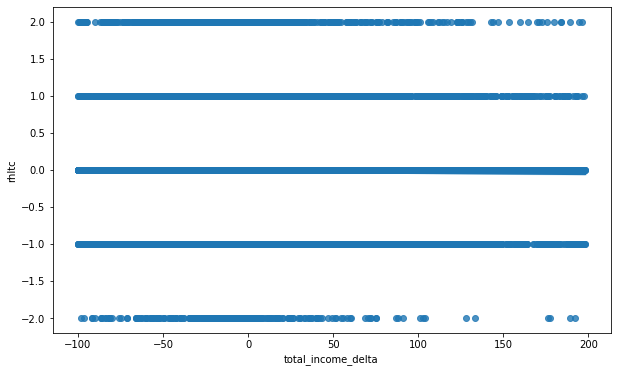

In [26]:
# make line plot of rhltc over total_income

income_health_df = df[(df['rhltc'] != '.m') & (df['n_jobs'] == 1)]
income_health_df['rhltc'] = income_health_df['rhltc'].astype(int)
income_health_df = income_health_df.dropna(subset=['total_income'])

q95 = income_health_df['total_income_delta'].quantile(0.95)
tmp = income_health_df[income_health_df['total_income_delta'] < q95]

# make lineplot of rhltc over total_income_delta in tmp
plt.figure(figsize=(10, 6))
sns.regplot(x='total_income_delta', y='rhltc', data=tmp)

plt.show()

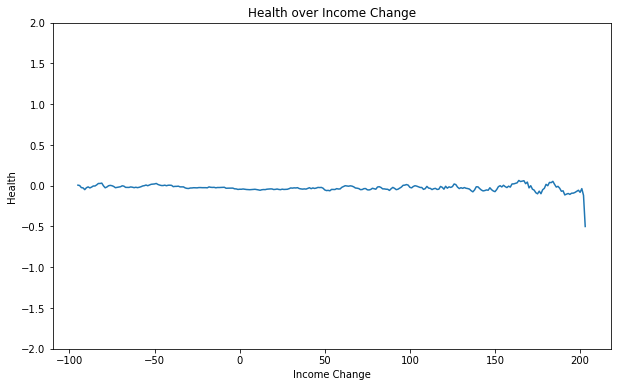

In [27]:
step = 10
groups_borders = [(x, x + 10) for x in range(-100, 200)]
x_values = [x + step / 2 for x, _ in groups_borders]
y_values = []

for left, right in groups_borders:
    y_values.append(tmp[(tmp['total_income_delta'] >= left) & (tmp['total_income_delta'] < right)]['rhltc'].mean())

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.title('Health over Income Change')
plt.xlabel('Income Change')
plt.ylabel('Health')

plt.ylim(-2, 2)

plt.show()

## Графики, связанные с браком

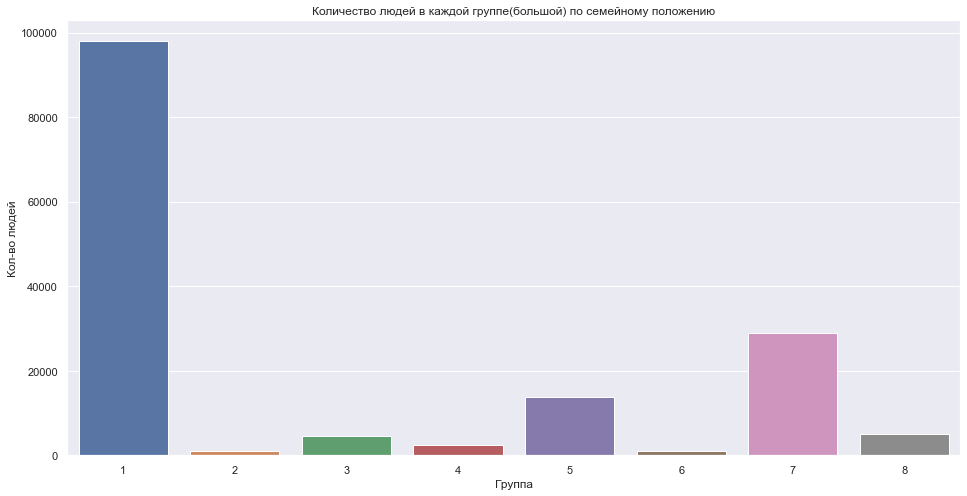

In [56]:
# plot amount of people in each rmstat group
plt.figure(figsize=(16, 8))

sns.countplot(x='rmstat', data=rmstat_df)
plt.title('Количество людей в каждой группе(большой) по семейному положению')
plt.xlabel('Группа')
plt.ylabel('Кол-во людей')

plt.show()

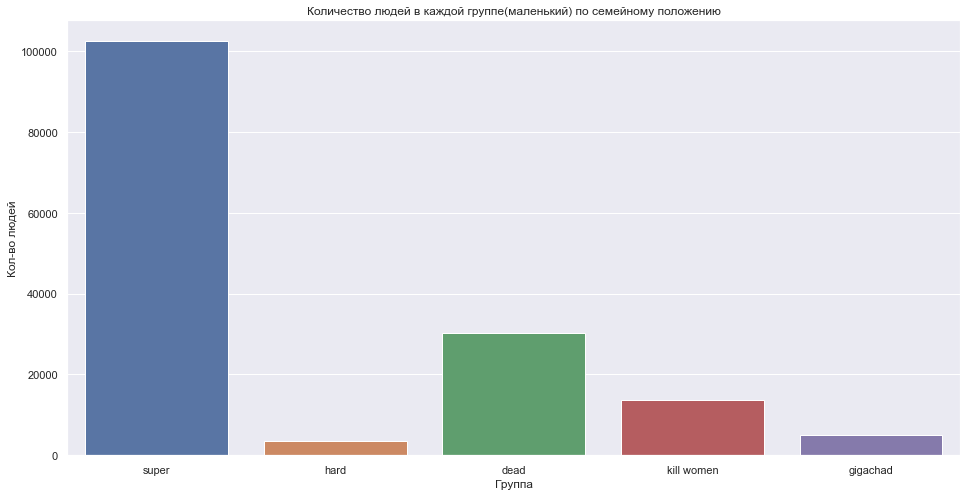

In [57]:
# plot amount of people in each mariage group
plt.figure(figsize=(16, 8))
sns.countplot(x='mariage_group', data=rmstat_df)
plt.title('Количество людей в каждой группе(маленький) по семейному положению')
plt.xlabel('Группа')
plt.ylabel('Кол-во людей')

plt.show()

In [34]:
all_mean_rhltc = rmstat_df['rhltc'].mean()
all_mean_rhltc

-0.14232650081718873

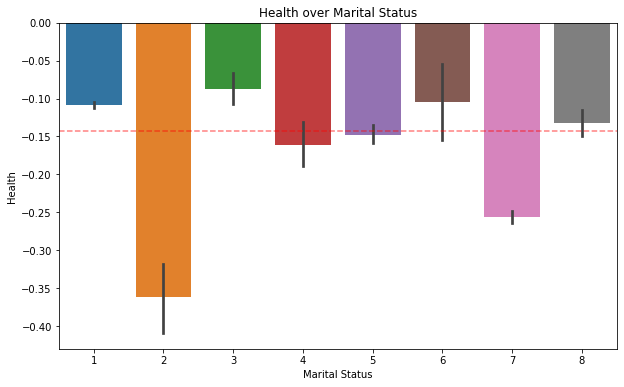

In [35]:
# plot mean rhltc by rmstat
plt.figure(figsize=(10, 6))
sns.barplot(x='rmstat', y='rhltc', data=rmstat_df)
plt.title('Health over Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Health')

plt.axhline(all_mean_rhltc, color='r', linestyle='--', alpha=0.5)

plt.show()

## Попытка в статанализ

In [45]:
rhltc_rmstat_pivot = single.groupby(['rmstat', 'rhltc'])['rhltc'].count().unstack('rhltc')
rhltc_rmstat_pivot = rhltc_rmstat_pivot.fillna(0)
rhltc_rmstat_pivot

rhltc,-2,-1,0,1,2
rmstat,,,,,
1,1362.0,14766.0,53303.0,6382.0,1537.0
2,12.0,28.0,44.0,17.0,0.0
3,21.0,356.0,1274.0,197.0,19.0
4,11.0,140.0,322.0,66.0,6.0
5,119.0,1154.0,2653.0,571.0,69.0
6,0.0,3.0,0.0,3.0,0.0
7,815.0,4429.0,8633.0,978.0,281.0
8,93.0,916.0,2668.0,410.0,63.0


In [46]:
chi2_contingency(rhltc_rmstat_pivot)

(2018.8390402349528,
 0.0,
 28,
 array([[1.81441126e+03, 1.62513975e+04, 5.13799804e+04, 6.43135334e+03,
         1.47285747e+03],
        [2.36917307e+00, 2.12203122e+01, 6.70895672e+01, 8.39775937e+00,
         1.92318817e+00],
        [4.37945161e+01, 3.92260622e+02, 1.24016061e+03, 1.55233829e+02,
         3.55504189e+01],
        [1.27841517e+01, 1.14505645e+02, 3.62017962e+02, 4.53146422e+01,
         1.03775995e+01],
        [1.07105388e+02, 9.59326192e+02, 3.03297984e+03, 3.79645241e+02,
         8.69433384e+01],
        [1.40742955e-01, 1.26061260e+00, 3.98551884e+00, 4.98876794e-01,
         1.14248802e-01],
        [3.55047560e+02, 3.18010540e+03, 1.00541355e+04, 1.25849986e+03,
         2.88211645e+02],
        [9.73472103e+01, 8.71923718e+02, 2.75665053e+03, 3.45056450e+02,
         7.90220881e+01]]))

In [49]:
rhltc_rmstat_pivot = rmstat_df.groupby(['mariage_group', 'rhltc'])['rhltc'].count().unstack('rhltc').reindex(['super', 'hard', 'dead', 'gigachad', 'kill women'])
# rhltc_rmstat_pivot = rhltc_rmstat_pivot.fillna(0)
rhltc_rmstat_pivot

rhltc,-2,-1,0,1,2
mariage_group,,,,,
super,1984,19721,70213,8399,2147
hard,146,783,2094,354,110
dead,1112,8696,17730,2169,451
gigachad,115,1098,3199,496,85
kill women,386,3290,8284,1436,301


In [59]:
chi2_contingency(rhltc_rmstat_pivot)

(2026.5516661029203,
 0.0,
 16,
 array([[ 2477.55316249, 22232.44873675, 67197.75502426,  8508.27367102,
          2047.96940549],
        [   84.31476302,   756.60279459,  2286.83802867,   289.54901517,
            69.69539855],
        [  729.21268225,  6543.62692265, 19778.16497523,  2504.22116422,
           602.77425565],
        [  120.72945562,  1083.37188225,  3274.50022287,   414.60230363,
            99.79613563],
        [  331.18993663,  2971.94966376,  8982.74174898,  1137.35384596,
           273.76480468]]))

## И снова графики, но теперь по группам и возростам

In [73]:
# rename ragender 1 for male, 2 for female
rmstat_df['ragender'].replace({1: 'male', 2: 'female'}, inplace=True)

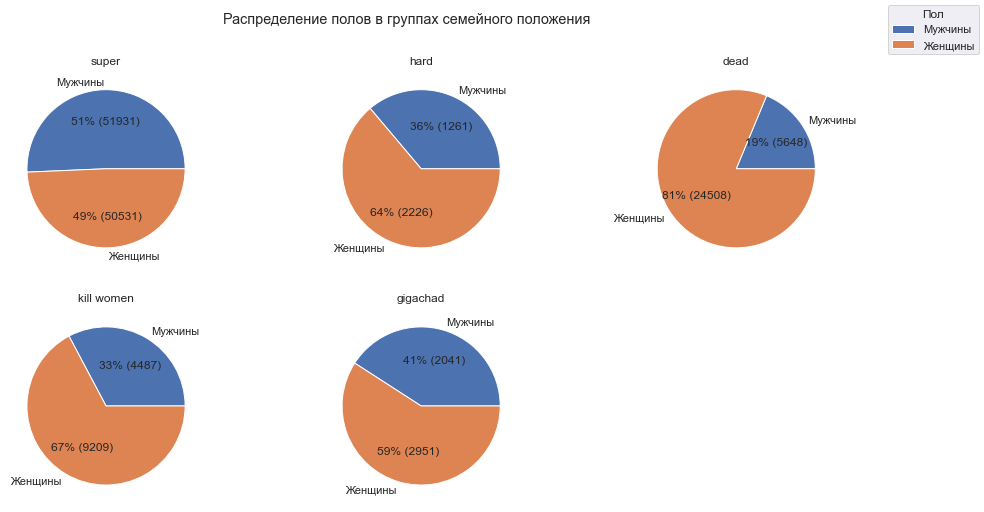

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

for i, group in enumerate(rmstat_df['mariage_group'].unique()):
    row, col = i // 3, i % 3

    value_counts = rmstat_df[rmstat_df['mariage_group'] == group]['ragender'].value_counts().sort_index()

    ax[row, col].pie(value_counts, labels=['Мужчины', 'Женщины'], autopct=lambda x: f'{x:.0f}% ({int(x * value_counts.sum() / 100)})')
    ax[row, col].set_title(group)

ax[-1, -1].axis('off')
fig.legend(title='Пол', labels=['Мужчины', 'Женщины'])
fig.suptitle('Распределение полов в группах семейного положения')
plt.show()

In [156]:
def make_plotly_age_group_plot(group):
    age_groups = ['young', 'middle', 'old', 'dead outside']
    y_ticks = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2]

    tmp = rmstat_df[rmstat_df['mariage_group'] == group]
    mean_in_group = tmp['rhltc'].mean()

    fig = go.Figure()

    fig.add_trace(go.Bar(name='Мужчины',
        x=age_groups,
        y=tmp[tmp['ragender'] == 1].groupby('age_group')['rhltc'].mean().reindex(age_groups),
        marker_color='rgb(85, 177, 242)'
    ))

    fig.add_trace(go.Bar(name='Женщины',
        x=age_groups,
        y=tmp[tmp['ragender'] == 2].groupby('age_group')['rhltc'].mean().reindex(age_groups), 
        marker_color='rgb(242, 111, 85)'
    ))

    fig.update_layout(
        barmode='group',
        width=800, height=500,
        title=f'Среднее изменение здоровья по полу и группе возраста в группе брака {group}',
        xaxis_title='Группа возраста',
        yaxis_title='Среднее изменение здоровья',
        yaxis = dict(
            tickmode = 'array',
            tickvals = y_ticks,
            ticktext = y_ticks
        )
    )
    fig.update_yaxes(range=[-1, 0.2])

    fig.add_hline(
        y=mean_in_group,
        line_dash='dash',
        line_color='black',
        line_width=1,
        annotation_text=f'Среднее по группе: {mean_in_group:.2f}',
        annotation_position='bottom left'
    )

    fig.show()

In [157]:
make_plotly_age_group_plot('super')

In [158]:
make_plotly_age_group_plot('hard')

In [159]:
make_plotly_age_group_plot('dead')

In [160]:
make_plotly_age_group_plot('gigachad')

In [161]:
make_plotly_age_group_plot('kill women')

## Некрасивые и/или не рабочие графики

In [87]:
def draw_health_by_group_plot(selector, title, order=['young', 'middle', 'old', 'dead outside'], gender_hue=False):
    tmp = rmstat_df[selector]
    all_mean = tmp['rhltc'].mean()

    plt.figure(figsize=(16, 8))

    if not gender_hue:
        sns.barplot(x='age_group', y='rhltc', data=tmp, order=order)
    else:
        sns.barplot(x='age_group', y='rhltc', data=tmp, order=order, hue='ragender')
        plt.legend(title='Пол', labels=['Мужчины', 'Женщины'])
        
    plt.title(title)
    plt.xlabel('Группа возраста')
    plt.ylabel('Среднее изменение здоровья')

    plt.axhline(all_mean, color='red', linestyle='--', alpha=.5)

    plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

sns.barplot(x='age_group', y='rhltc', data=rmstat_df, order=['young', 'middle', 'old', 'dead outside'], hue='ragender')

plt.legend(title='Пол', labels=['Мужчины', 'Женщины'])

plt.show()

In [ ]:
selector = (rmstat_df['mariage_group'] == 'super') & (rmstat_df['age_group'] != 'dead outside')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё хорошо(super)', order=['young', 'middle', 'old'], gender_hue=True)

In [ ]:
selector = (rmstat_df['mariage_group'] == 'hard')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё сложно(hard)', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
selector = (rmstat_df['mariage_group'] == 'dead')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё очень плохо(dead)', gender_hue=True)

In [ ]:
selector = (rmstat_df['mariage_group'] == 'gigachad')
draw_health_by_group_plot(selector, 'Люди, которые в жизни женщин не трогали(gigachad)', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
selector = (rmstat_df['mariage_group'] == 'kill women')
draw_health_by_group_plot(selector, 'Группу не помню, но это kill women', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='rhltc', data=rmstat_df, hue='ragender', order=['young', 'middle', 'old', 'dead outside'])
plt.title('Health over Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Health')

# horizontal line for all_mean_rhltc
plt.axhline(all_mean_rhltc, color='red', linestyle='--', alpha=.5)

plt.show()

# Подвал 

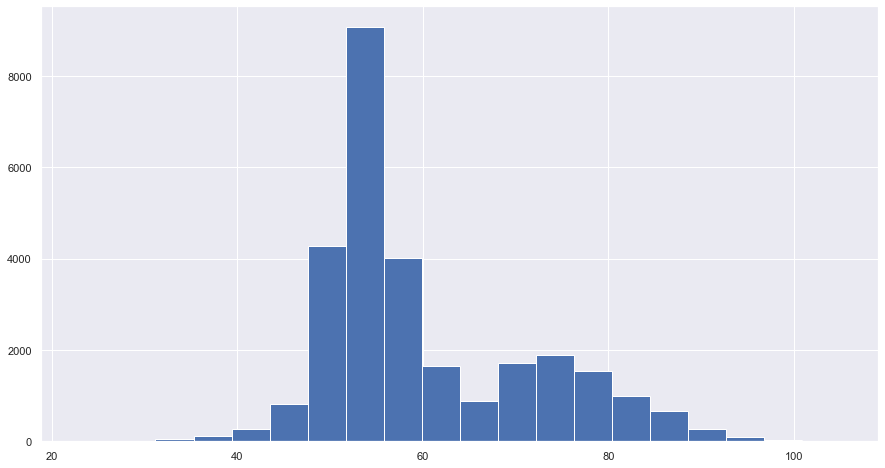

In [11]:
# histogram of ragey_b of index_wave = 1
sns.set()

plt.figure(figsize=(15, 8))
df[df['index_wave'] == 1]['ragey_b'].hist(bins=20)
plt.show()

In [13]:
df[(df['index_wave'] == 1) & (df['ragey_b'] > 50)].shape

(25148, 49)

In [14]:
df[(df['index_wave'] == 1) & (df['ragey_b'] <= 50)].shape

(3159, 49)

In [17]:
df[(df['index_wave'] == 1) & (df['riearn'] == 0)].shape

(12825, 49)

In [21]:
tmp = df[(df['index_wave'] == 1) & (df['ragey_b'] > 65)]

tmp[tmp['riearn'] == 0].shape[0] / tmp.shape[0] * 100

89.73048920679526

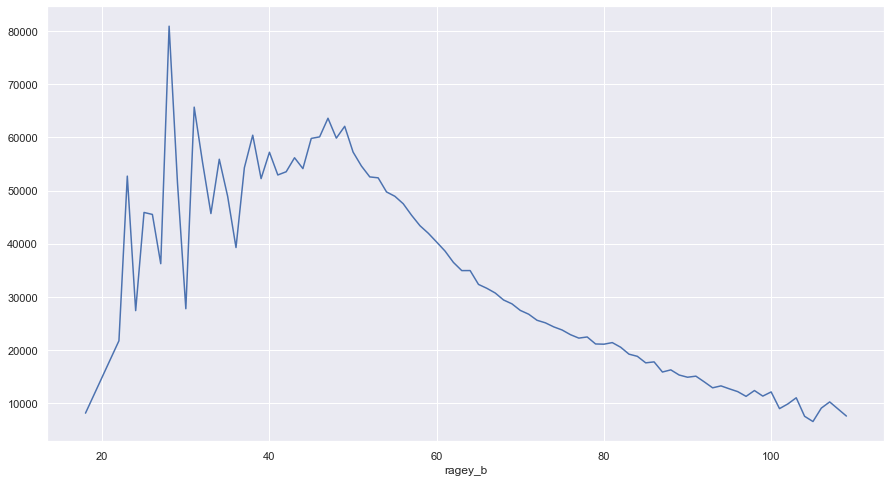

In [26]:
# plot median total_income by ragey_b in index_wave 1
plt.figure(figsize=(15, 8))
df[(df['total_income'] > 0)].groupby('ragey_b')['total_income'].median().plot()
plt.show()

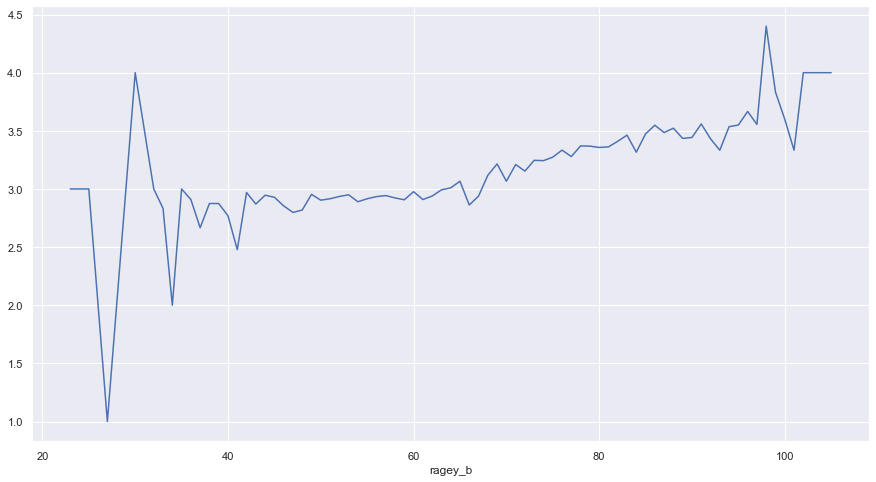

In [33]:
# plot the mean of rhltc by ragey_b
plt.figure(figsize=(15, 8))
tmp = df[(df['index_wave'] == 1) & (df['rhltc'] != '.m')]
tmp['rhltc'] = tmp['rhltc'].astype('int')
tmp.groupby('ragey_b')['rhltc'].mean().plot()
plt.show()

In [34]:
# percent of people with insured_gov
df[(df['insured_gov'] == 1)].shape[0] / df.shape[0] * 100

53.90575131323897

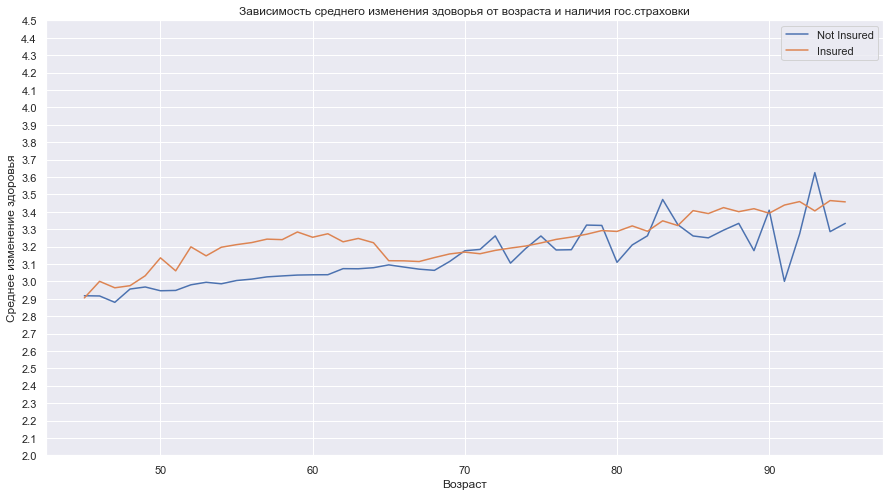

In [48]:
# line plot of mean of rhltc by ragey_b hue by insured_gov sns
plt.figure(figsize=(15, 8))
tmp = df[(df['rhltc'] != '.m') & (df['ragey_b'] >= 45) & (df['ragey_b'] <= 95)]
tmp['rhltc'] = tmp['rhltc'].astype('int')

sns.lineplot(x='ragey_b', y='rhltc', hue='insured_gov', data=tmp, ci=None)

plt.legend(['Not Insured', 'Insured'])
plt.yticks(np.arange(2, 4.6, 0.1))

plt.title('Зависимость среднего изменения здоворья от возраста и наличия гос.страховки')
plt.xlabel('Возраст')
plt.ylabel('Среднее изменение здоровья')

plt.show()